In [1]:
cd

C:\Users\jakia


In [2]:
cd ../../Amherst/ASTR-337/

C:\Amherst\ASTR-337


In [3]:
pip install photutils --user

^C
Note: you may need to restart the kernel to use updated packages.


In [30]:
# The standard fare, plus a few extra packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os.path
import math
%matplotlib inline

# Newer packages:
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from photutils.utils import calc_total_error
import astropy.stats as stat

from photutils.aperture import aperture_photometry, ApertureStats, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder

from IPython.display import Image
import matplotlib.image as mpimg

## Part 1: getting star position for the cluster and the std star images

In [139]:
# Star extraction function
def starExtractor(fitsfile, nsigma_value, fwhm_value):
    """
    Takes an image and outputs a list of all star coordinates above the defined threshold.
    Inputs:
        fitsfile (string): path to fits file
        nsigma_value (int): number of standard deviations away to use for a threshold
        fwhm_value (float): width of aperture for locating stars
    Outputs:
        xpos, ypos (arrays): arrays of centroid x and y positions of stars
    """

    # First, check if the region file exists yet, so it doesn't get overwritten
    regionfile = fitsfile.split(".")[0] + ".reg"

    if os.path.exists(regionfile) == True:
        print(regionfile, "already exists in this directory. Rename or remove the .reg file and run again.")
        return

    # get data of fitsfile
    image = fits.getdata(fitsfile)

    # *** Measure the median absolute standard deviation of the image: ***
    bkg_sigma = mad_std(image[~np.isnan(image)])

    # *** Define the parameters for DAOStarFinder ***
    daofind = DAOStarFinder(fwhm=fwhm_value, threshold=nsigma_value*bkg_sigma)

    # Apply DAOStarFinder to the image
    sources = daofind(image)
    nstars = len(sources)
    print("Number of stars found in ",fitsfile,":", nstars)

    # Define arrays of x-position and y-position
    xpos = np.array(sources['xcentroid'])
    ypos = np.array(sources['ycentroid'])

    # Write the positions to a .reg file based on the input file name
    if os.path.exists(regionfile) == False:
        f = open(regionfile, 'w')
        for i in range(0,len(xpos)):
            f.write('circle '+str(xpos[i])+' '+str(ypos[i])+' '+str(fwhm_value)+'\n')
        f.close()
        print("Wrote ", regionfile)
    
    return xpos, ypos # Return the x and y positions of each star as variables

In [40]:
avg_fwhm = np.mean([9,9,10.5,11,9])
avg_fwhm

9.7

In [44]:
v_stacked = 'Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image.fit' 
b_stacked = 'Final_project/CSJ_10_26_24/target/s_padded_Blue_stacked_image.fit'
r_stacked = 'Final_project/CSJ_10_26_24/target/s_padded_Red_stacked_image.fit'

std_v_stacked = 'Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image.fit' 
std_b_stacked = 'Final_project/CSJ_10_26_24/standard/s_padded_Blue_stacked_image.fit'
std_r_stacked = 'Final_project/CSJ_10_26_24/standard/s_padded_Red_stacked_image.fit'

### For Cluster

In [140]:
# number of star for nsigma = 10 is 894
# number of star for nsigma = 15 is 634
# we want around 500 stars so we choose nsignma=15
fitsfile = 'Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image.fit'
fwhm = avg_fwhm
nsigma = 15
x_pos, y_pos = starExtractor(fitsfile, nsigma, fwhm)

Number of stars found in  Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image.fit : 586
Wrote  Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image.reg


### For std star

In [96]:
# number of star for nsigma = 5 is 346
# number of star for nsigma = 4 is 2046
# we want around 500 stars, 4-sigma is too many, so we choose nsignma=5
fitsfile = 'Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image.fit'
fwhm = 15
nsigma = 5
std_x_pos, std_y_pos = starExtractor(fitsfile, nsigma, fwhm)

Number of stars found in  Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image.fit : 264
Wrote  Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image.reg


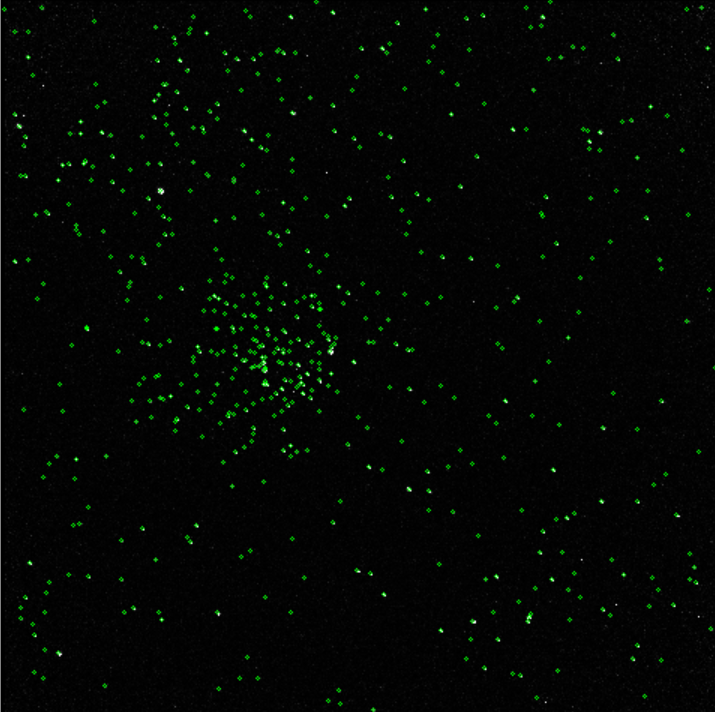

In [16]:
#Get screenshots of V-band images of your standard and cluster fields with regions showing the extracted stars—you will need these for Part 2.
Image("HW-11/cluster_reg.png")

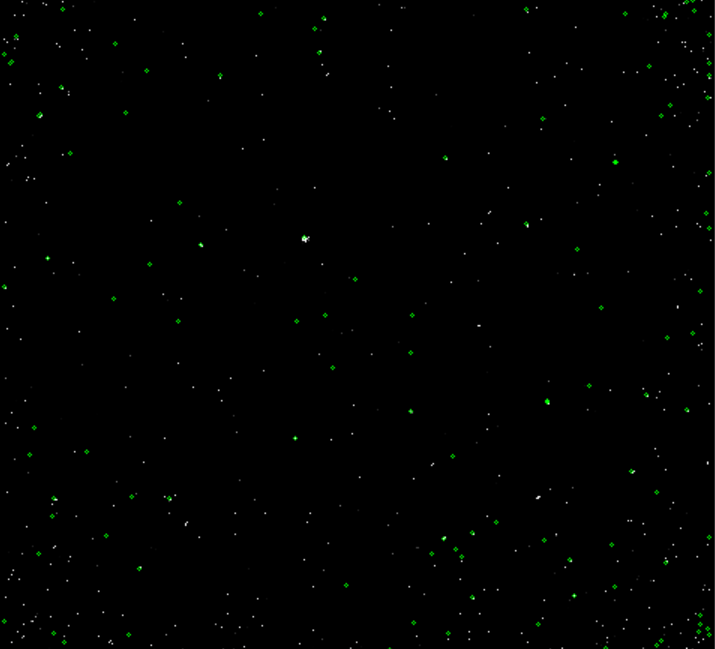

In [17]:
Image("HW-11/std_reg.png")

### Extracting the star positions for cluster and std star in all three filters

# Aperture Photometry

In [37]:
def bg_error_estimate(fitsfile):
    """
    Estimates background error in a fits file.
    Input:
        fitsfile (string): path to fits file
    Output:
        error_image (array): array of pixel errors
    """
    fitsdata = fits.getdata(fitsfile)
    hdr = fits.getheader(fitsfile)

    # What is happening in the next step? Read the docstring for sigma_clip.
    # Answer: removes data a certain number of standard deviations from the mean (ie keeps only the centered data)
    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)

    # Summarize the following steps. Answer:
    # Fills empty indicies in array with Nans
    # Makes array were each pixel is square root of previous pixel of last array
    # Sets NaN values equal to the median of the non-NaN values
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    bkg_error = np.sqrt(bkg_values_nan)
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)

    print("Writing the background-only error image: ", fitsfile.split('.')[0]+"_bgerror.fit")
    fits.writeto(fitsfile.split('.')[0]+"_bgerror.fit", bkg_error, hdr, overwrite=True)

    effective_gain = 1.4 # electrons per ADU

    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)

    print("Writing the total error image: ", fitsfile.split('.')[0]+"_error.fit")
    fits.writeto(fitsfile.split('.')[0]+"_error.fit", error_image, hdr, overwrite=True)

    return error_image

In [39]:
# Photometry function
def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    This function makes a table with star positions, sums for flux for stars, uncertainty in the sums, and bg subtracted star counts.
    
    Parameters:
    fitsfile (str): path to the image
    star_xpos (array): x positions of the stars
    star_ypos (array): y positions of the stars
    aperture_radius (float): aperture radius
    sky_inner (float): Inner radius of the sky annulus
    sky_outter (float): Outter radius of the sky annulus
    error_array (array): an array containing the total error
    
    Returns: a table containing photometry information
    """
    # *** Read in the data from the fits file:
    image = fits.getdata(fitsfile)

    star_pos = np.vstack([star_xpos, star_ypos]).T

    starapertures = CircularAperture(star_pos,r = aperture_radius)
    skyannuli = CircularAnnulus(star_pos, r_in = sky_inner, r_out = sky_outer)
    phot_apers = [starapertures, skyannuli]

    # What is new about the way we're calling aperture_photometry?
    # This is accounting for the annulus and including error
    phot_table = aperture_photometry(image, phot_apers, error=error_array)

    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area
    bkg_starap_sum = bkg_mean * starapertures.area
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum

    # Calculating mean and sum error for the background using annuli area and aperture area
    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area
    bkg_sum_err = bkg_mean_err * starapertures.area

    # Combining errors using error propagation
    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2))

    return phot_table


### Extracting photometry for the standard star images

In [97]:
# Measure the background of the image (V)
std_V_bgerror = bg_error_estimate(std_v_stacked)
std_V_phottable = measurePhotometry(std_v_stacked, star_xpos=std_x_pos, star_ypos=std_y_pos, \
                                    aperture_radius=15, sky_inner=18, sky_outer=23, error_array=std_V_bgerror)
std_V_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/standard/s_padded_Visual_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,238.05001314373052,13.202626026789366,2730.3074110985917,73.0335394585842,1231.8224134502664,53.943850061694384,1378.307201214153,94.01769530767606


In [98]:
# Measure the background of the R image
std_R_bgerror = bg_error_estimate(std_r_stacked)
std_R_phottable = measurePhotometry(std_r_stacked, star_xpos=std_x_pos, star_ypos=std_y_pos, \
                                    aperture_radius=15, sky_inner=18, sky_outer=23, error_array=std_R_bgerror)
std_R_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/standard/s_padded_Red_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/standard/s_padded_Red_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,238.05001314373052,13.202626026789366,-696.2075772337156,53.019792314523244,-472.4755925733062,43.677556942206344,-177.63680489716,71.47884440624668


In [159]:
# Measure the background of the R image
std_B_bgerror = bg_error_estimate(std_b_stacked)
std_B_phottable = measurePhotometry(std_b_stacked, star_xpos=std_x_pos, star_ypos=std_y_pos, \
                                    aperture_radius=15, sky_inner=18, sky_outer=23, error_array=std_B_bgerror)
std_B_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/standard/s_padded_Blue_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/standard/s_padded_Blue_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,238.05001314373052,13.202626026789366,-696.2075772337156,48.5155619852882,-472.4755925733062,39.966984567291796,-177.63680489716,65.40644832888411


In [160]:
columns = ['id','xcenter', 'ycenter','Bflux','Bfluxerr','Vflux','Vfluxerr','Rflux','Rfluxerr']
std_fluxtable = pd.DataFrame(
    {'id'      : std_V_phottable['id'],
     'xcenter' : std_V_phottable['xcenter'],
     'ycenter' : std_V_phottable['ycenter'],
     'Bflux'   : std_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': std_B_phottable['bg_sub_star_cts_err'], 
     'Vflux'   : std_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': std_V_phottable['bg_sub_star_cts_err'], 
     'Rflux'   : std_R_phottable['bg_subtracted_star_counts'],
     'Rfluxerr': std_R_phottable['bg_sub_star_cts_err']}, columns=columns)
std_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr
0,1,238.050013,13.202626,-177.636805,65.406448,1378.307201,94.017695,-177.636805,71.478844
1,2,844.610956,16.171182,-138.034704,67.085644,525.907262,88.638064,-138.034704,73.313938
2,3,1183.477247,15.965578,-142.060196,66.974222,266.021993,89.648065,-142.060196,73.192171
3,4,76.960295,18.005138,-91.761690,68.353401,1093.658574,101.671169,-91.761690,74.699395
4,5,323.266536,15.864044,-144.004805,66.920330,377.313751,91.759968,-144.004805,73.133276


### Extracting photometry for the cluster images

In [141]:
m52_V_bgerror = bg_error_estimate(v_stacked)
m52_V_phottable = measurePhotometry(v_stacked, star_xpos=x_pos, star_ypos=y_pos, \
                                    aperture_radius=10, sky_inner=11, sky_outer=16, error_array=m52_V_bgerror)
m52_V_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/target/s_padded_Visual_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,2096.89804252163,48.102927965626314,17507.708011332063,123.40084066268915,4167.391454427973,83.56730791260382,14420.751378422452,138.05647077668834


In [161]:
m52_B_bgerror = bg_error_estimate(b_stacked)
m52_B_phottable = measurePhotometry(b_stacked, star_xpos=x_pos, star_ypos=y_pos, \
                                    aperture_radius=10, sky_inner=11, sky_outer=16, error_array=m52_B_bgerror)
m52_B_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/target/s_padded_Blue_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/target/s_padded_Blue_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,2096.89804252163,48.102927965626314,8483.280966586051,92.942408094038,4856.7381475737075,83.03380475919853,4885.69715356849,111.45108109053676


In [142]:
m52_R_bgerror = bg_error_estimate(r_stacked)
m52_R_phottable = measurePhotometry(r_stacked, star_xpos=x_pos, star_ypos=y_pos, \
                                    aperture_radius=10, sky_inner=11, sky_outer=16, error_array=m52_R_bgerror)
m52_R_phottable[0]

C:\Users\jakia\AppData\Local\Temp\ipykernel_6072\4133196617.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  Final_project/CSJ_10_26_24/target/s_padded_Red_stacked_image_bgerror.fit
Writing the total error image:  Final_project/CSJ_10_26_24/target/s_padded_Red_stacked_image_error.fit


id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_star_counts,bg_sub_star_cts_err
,pix,pix,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64
1,2096.89804252163,48.102927965626314,874.8489728675564,57.803958265035654,1341.2229107591997,68.30623421969845,-118.6494795466657,76.82040942899118


In [162]:
columns = ['id','xcenter', 'ycenter','Bflux','Bfluxerr','Vflux','Vfluxerr','Rflux','Rfluxerr']
m52_fluxtable = pd.DataFrame(
    {'id'      : m52_V_phottable['id'],
     'xcenter' : m52_V_phottable['xcenter'],
     'ycenter' : m52_V_phottable['ycenter'],
     'Bflux'   : m52_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': m52_B_phottable['bg_sub_star_cts_err'], 
     'Vflux'   : m52_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': m52_V_phottable['bg_sub_star_cts_err'], 
     'Rflux'   : m52_R_phottable['bg_subtracted_star_counts'],
     'Rfluxerr': m52_R_phottable['bg_sub_star_cts_err']}, columns=columns)
m52_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr
0,1,2096.898043,48.102928,4885.697154,111.451081,14420.751378,138.056471,-118.649480,76.820409
1,2,1906.460422,79.839973,342.974691,82.812382,1491.973430,93.066841,2111.324904,101.785633
2,3,3078.350570,91.936442,185.225228,84.542654,1606.736335,96.080731,887.105172,104.181234
3,4,1839.516630,97.741082,1349.247866,92.685663,4810.918033,106.148731,4345.351604,113.144373
4,5,3032.204856,114.080171,315.655484,86.187121,1541.156251,94.680079,1041.442133,100.095058


## Calculating Instrumental Magnitudes and Measuring Zeropoints

### Normalize by exp time

In [163]:
header_m52V= fits.getheader(v_stacked)
print(header_m52V['EXPTIME'])
header_m52R = fits.getheader(r_stacked)
print(header_m52R['EXPTIME'])
header_m52B = fits.getheader(b_stacked)
print(header_m52B['EXPTIME'])

header_stdR = fits.getheader(std_r_stacked)
print(header_stdR['EXPTIME'])
header_stdV = fits.getheader(std_v_stacked)
print(header_stdV['EXPTIME'])
header_stdB = fits.getheader(std_b_stacked)
print(header_stdB['EXPTIME'])

# new m52 flux
m52_fluxtable["Bflux_1sec"] = m52_fluxtable["Bflux"] / header_m52B['EXPTIME']
m52_fluxtable["Vflux_1sec"] = m52_fluxtable["Vflux"] / header_m52V['EXPTIME']
m52_fluxtable["Rflux_1sec"] = m52_fluxtable["Rflux"] / header_m52R['EXPTIME']
# new uncert
m52_fluxtable["Bflux_1sec_err"] = m52_fluxtable["Bfluxerr"] / header_m52B['EXPTIME']
m52_fluxtable["Vflux_1sec_err"] = m52_fluxtable["Vfluxerr"] / header_m52V['EXPTIME']
m52_fluxtable["Rflux_1sec_err"] = m52_fluxtable["Rfluxerr"] / header_m52R['EXPTIME']

# new std flux
std_fluxtable["Bflux_1sec"] = std_fluxtable["Bflux"] / header_stdB['EXPTIME']
std_fluxtable["Vflux_1sec"] = std_fluxtable["Vflux"] / header_stdV['EXPTIME']
std_fluxtable["Rflux_1sec"] = std_fluxtable["Rflux"] / header_stdR['EXPTIME']
# new std uncert
std_fluxtable["Bflux_1sec_err"] = std_fluxtable["Bfluxerr"] / header_stdB['EXPTIME']
std_fluxtable["Vflux_1sec_err"] = std_fluxtable["Vfluxerr"] / header_stdV['EXPTIME']
std_fluxtable["Rflux_1sec_err"] = std_fluxtable["Rfluxerr"] / header_stdR['EXPTIME']

10.0
10.0
10.0
5.0
5.0
5.0


In [164]:
# Check that new columns were added
std_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr,Bflux_1sec,Vflux_1sec,Rflux_1sec,Bflux_1sec_err,Vflux_1sec_err,Rflux_1sec_err
0,1,238.050013,13.202626,-177.636805,65.406448,1378.307201,94.017695,-177.636805,71.478844,-35.527361,275.661440,-35.527361,13.081290,18.803539,14.295769
1,2,844.610956,16.171182,-138.034704,67.085644,525.907262,88.638064,-138.034704,73.313938,-27.606941,105.181452,-27.606941,13.417129,17.727613,14.662788
2,3,1183.477247,15.965578,-142.060196,66.974222,266.021993,89.648065,-142.060196,73.192171,-28.412039,53.204399,-28.412039,13.394844,17.929613,14.638434
3,4,76.960295,18.005138,-91.761690,68.353401,1093.658574,101.671169,-91.761690,74.699395,-18.352338,218.731715,-18.352338,13.670680,20.334234,14.939879
4,5,323.266536,15.864044,-144.004805,66.920330,377.313751,91.759968,-144.004805,73.133276,-28.800961,75.462750,-28.800961,13.384066,18.351994,14.626655


In [165]:
# Check that new columns were added
m52_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr,Bflux_1sec,Vflux_1sec,Rflux_1sec,Bflux_1sec_err,Vflux_1sec_err,Rflux_1sec_err
0,1,2096.898043,48.102928,4885.697154,111.451081,14420.751378,138.056471,-118.649480,76.820409,488.569715,1442.075138,-11.864948,11.145108,13.805647,7.682041
1,2,1906.460422,79.839973,342.974691,82.812382,1491.973430,93.066841,2111.324904,101.785633,34.297469,149.197343,211.132490,8.281238,9.306684,10.178563
2,3,3078.350570,91.936442,185.225228,84.542654,1606.736335,96.080731,887.105172,104.181234,18.522523,160.673634,88.710517,8.454265,9.608073,10.418123
3,4,1839.516630,97.741082,1349.247866,92.685663,4810.918033,106.148731,4345.351604,113.144373,134.924787,481.091803,434.535160,9.268566,10.614873,11.314437
4,5,3032.204856,114.080171,315.655484,86.187121,1541.156251,94.680079,1041.442133,100.095058,31.565548,154.115625,104.144213,8.618712,9.468008,10.009506


### Calculate instrumental magnitudes

In [166]:
m52_fluxtable["Binst"] = -2.5*(np.log10(m52_fluxtable["Bflux_1sec"]))
m52_fluxtable["Vinst"] = -2.5*(np.log10(m52_fluxtable["Vflux_1sec"]))
m52_fluxtable["Rinst"] = -2.5*(np.log10(m52_fluxtable["Rflux_1sec"]))

std_fluxtable["Binst"] = -2.5*(np.log10(std_fluxtable["Bflux_1sec"]))
std_fluxtable["Vinst"] = -2.5*(np.log10(std_fluxtable["Vflux_1sec"]))
std_fluxtable["Rinst"] = -2.5*(np.log10(std_fluxtable["Rflux_1sec"]))

C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jakia\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered

### Propagate errors

In [167]:
m52_fluxtable["Binst_err"] = 2.5 * 0.434 * (m52_fluxtable["Bflux_1sec_err"]/m52_fluxtable["Bflux_1sec"])
m52_fluxtable["Vinst_err"] = 2.5 * 0.434 * (m52_fluxtable["Vflux_1sec_err"]/m52_fluxtable["Vflux_1sec"])
m52_fluxtable["Rinst_err"] = 2.5 * 0.434 * (m52_fluxtable["Rflux_1sec_err"]/m52_fluxtable["Rflux_1sec"])

std_fluxtable["Binst_err"] = 2.5 * 0.434 * (std_fluxtable["Bflux_1sec_err"]/std_fluxtable["Bflux_1sec"])
std_fluxtable["Vinst_err"] = 2.5 * 0.434 * (std_fluxtable["Vflux_1sec_err"]/std_fluxtable["Vflux_1sec"])
std_fluxtable["Rinst_err"] = 2.5 * 0.434 * (std_fluxtable["Rflux_1sec_err"]/std_fluxtable["Rflux_1sec"])

### Get standard star magnitudes

In [170]:
target_value = 1756
tolerance = 10

indices = std_fluxtable.index[(std_fluxtable['xcenter'] >= target_value - tolerance) & (std_fluxtable['xcenter'] <= target_value + tolerance)].tolist()

print(indices)

[49, 75]


In [172]:
# Print the row in the standard star table corresponding to the standard star
std_fluxtable.loc[[75]]

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr,Bflux_1sec,...,Rflux_1sec,Bflux_1sec_err,Vflux_1sec_err,Rflux_1sec_err,Binst,Vinst,Rinst,Binst_err,Vinst_err,Rinst_err
75,76,1753.287906,1545.132752,72741.670056,256.02027,74834.070572,264.15938,402548.55952,555.726121,14548.334011,...,80509.711904,51.204054,52.831876,111.145224,-10.407033,-10.437823,-12.264621,0.003819,0.00383,0.001498


In [169]:
np.max(std_fluxtable['Vflux'])

74834.07057181487

In [ ]:
#Get standard star magnitudes from SIMBAD and post here

In [90]:
real_V_mag = 8.951
real_R_mag = 8.475
real_B_mag = 9.817

In [173]:
#calculate the zeropoints for each band
loc = 75
magzp_B = real_B_mag - std_fluxtable['Binst'][loc]
magzp_B_error = np.sqrt((std_fluxtable['Binst_err'][loc]**2 + 0.004**2))
magzp_V = real_V_mag - std_fluxtable['Vinst'][loc]
magzp_V_error = np.sqrt((std_fluxtable['Vinst_err'][loc]**2 + 0.004**2))
magzp_R = real_R_mag - std_fluxtable['Rinst'][loc]
magzp_R_error = np.sqrt((std_fluxtable['Rinst_err'][loc]**2 + 0.004**2))

In [174]:
print("Zeropoint in B: ", magzp_B, "+/-", magzp_B_error)
print("Zeropoint in V: ", magzp_V, "+/-", magzp_V_error)
print("Zeropoint in R: ", magzp_R, "+/-", magzp_R_error)

Zeropoint in B:  20.22403315835617 +/- 0.00553017398882311
Zeropoint in V:  19.388823412046364 +/- 0.0055379364356324305
Zeropoint in R:  20.739620681412603 +/- 0.004271252206816761


## Calibrate Cluster Photometry using the Zeropoint Offsets 

In [175]:
#Calibrate Cluster Photometry using the Zeropoint Offsets

# Define calibrated dataframe function
def zpcalc(magzp, magzp_err, filtername, dataframe):

    '''
    Calibrates V and R fluxxes and their uncertainties in dataframe.
    Inputs:
        magzp (float): the zeropoint
        magzp_err (float): the error in zeropoint
        filtername (string): filter type
        dataframe (pandas dataframe): star dataframe
    Outputs:
        dataframe (pandas dataframe): dataframe with added calibrated magnitude and error columns
    '''

    #extract column data

    maginst = dataframe[filtername + 'inst']
    maginst_err = dataframe[filtername + 'inst_err']

    #calculate magnitude

    calibrated_mag = maginst + magzp
    calibrated_mag_err = np.sqrt(maginst_err**2 + magzp_err**2)

    #add to dataframe

    dataframe = dataframe.assign(**{filtername + 'mag' : calibrated_mag})
    dataframe = dataframe.assign(**{filtername + 'mag_err' : calibrated_mag_err})


    #dataframe.insert(0, filtername + 'mag', calibrated_mag)
    #dataframe.insert(1, filtername + 'mag_err', calibrated_mag_err)

    return dataframe

In [176]:
# Apply function to dataframes

m52_fluxtable = zpcalc(magzp_B, magzp_B_error, "B", m52_fluxtable)
m52_fluxtable = zpcalc(magzp_V, magzp_V_error, "V", m52_fluxtable)
m52_fluxtable = zpcalc(magzp_R, magzp_R_error, "R", m52_fluxtable)

In [179]:
# Add V-R column and V-R error column
m52_fluxtable["V-R"] = m52_fluxtable["Vmag"] - m52_fluxtable["Rmag"]
m52_fluxtable["V-R_err"] = np.sqrt((m52_fluxtable["Vmag_err"])**2 + (m52_fluxtable["Rmag_err"])**2)

In [180]:
# Add V-R column and V-R error column
m52_fluxtable["B-V"] = m52_fluxtable["Bmag"] - m52_fluxtable["Vmag"]
m52_fluxtable["B-V_err"] = np.sqrt((m52_fluxtable["Vmag_err"])**2 + (m52_fluxtable["Bmag_err"])**2)

In [181]:
m52_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr,Rflux,Rfluxerr,Bflux_1sec,...,Bmag,Bmag_err,Vmag,Vmag_err,Rmag,Rmag_err,B-V,B-V_err,V-R,V-R_err
0,1,2096.898043,48.102928,4885.697154,111.451081,14420.751378,138.056471,-118.649480,76.820409,488.569715,...,13.501717,0.025361,11.491354,0.011771,NaN,0.702504,2.010363,0.027960,NaN,0.702602
1,2,1906.460422,79.839973,342.974691,82.812382,1491.973430,93.066841,2111.324904,101.785633,34.297469,...,16.385878,0.262035,13.954421,0.067907,14.928233,0.052481,2.431457,0.270691,-0.973812,0.085823
2,3,3078.350570,91.936442,185.225228,84.542654,1606.736335,96.080731,887.105172,104.181234,18.522523,...,17.054783,0.495259,13.873962,0.065117,15.869683,0.127493,3.180821,0.499522,-1.995721,0.143160
3,4,1839.516630,97.741082,1349.247866,92.685663,4810.918033,106.148731,4345.351604,113.144373,134.924787,...,14.898804,0.074738,12.683254,0.024572,14.144558,0.028572,2.215550,0.078674,-1.461305,0.037685
4,5,3032.204856,114.080171,315.655484,86.187121,1541.156251,94.680079,1041.442133,100.095058,31.565548,...,16.476000,0.296302,13.919207,0.066886,15.695533,0.104369,2.556793,0.303757,-1.776326,0.123962


In [182]:
m52_fluxtable.columns

Index(['id', 'xcenter', 'ycenter', 'Bflux', 'Bfluxerr', 'Vflux', 'Vfluxerr',
       'Rflux', 'Rfluxerr', 'Bflux_1sec', 'Vflux_1sec', 'Rflux_1sec',
       'Bflux_1sec_err', 'Vflux_1sec_err', 'Rflux_1sec_err', 'Binst', 'Vinst',
       'Rinst', 'Binst_err', 'Vinst_err', 'Rinst_err', 'Bmag', 'Bmag_err',
       'Vmag', 'Vmag_err', 'Rmag', 'Rmag_err', 'B-V', 'B-V_err', 'V-R',
       'V-R_err'],
      dtype='object')

In [183]:
std_fluxtable.columns

Index(['id', 'xcenter', 'ycenter', 'Bflux', 'Bfluxerr', 'Vflux', 'Vfluxerr',
       'Rflux', 'Rfluxerr', 'Bflux_1sec', 'Vflux_1sec', 'Rflux_1sec',
       'Bflux_1sec_err', 'Vflux_1sec_err', 'Rflux_1sec_err', 'Binst', 'Vinst',
       'Rinst', 'Binst_err', 'Vinst_err', 'Rinst_err'],
      dtype='object')

In [184]:
# Finally, save both calibrated dataframes (standard and m52) here as .csv files;
# These can later be read into Excel, Google Sheets, back into pandas, etc. for future use

std_fluxtable.to_csv('std_star.csv')
m52_fluxtable.to_csv('M52_photometry.csv')

## Plotting the Color-Magnitude Diagram

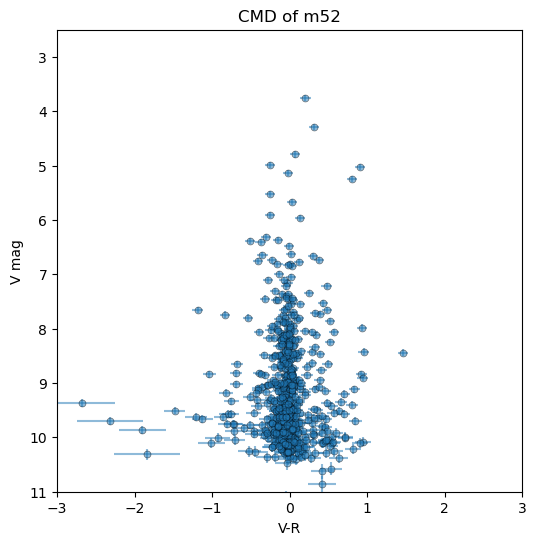

In [158]:
# Add code to plot your CMD here. 
# Don't forget to add a title and axis labels!
plt.figure(figsize=(6,6))
plt.errorbar(m52_fluxtable["V-R"], m52_fluxtable["Vmag"], xerr = m52_fluxtable["V-R_err"], yerr = m52_fluxtable["Vmag_err"], 
             marker = 'o', linestyle='None', alpha = 0.5, markeredgecolor = 'black', markeredgewidth = 0.5, markersize = 5)
plt.title("CMD of m52")
plt.xlabel("V-R")
plt.ylabel("V mag")

plt.ylim([11, 2.5])
plt.xlim([-3, 3])
plt.show()

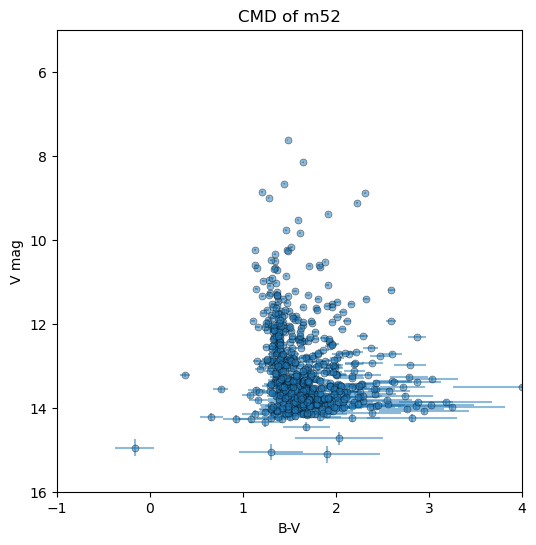

In [187]:
# Add code to plot your CMD here. 
# Don't forget to add a title and axis labels!
plt.figure(figsize=(6,6))
plt.errorbar(m52_fluxtable["B-V"], m52_fluxtable["Vmag"], xerr = m52_fluxtable["B-V_err"], yerr = m52_fluxtable["Vmag_err"], 
             marker = 'o', linestyle='None', alpha = 0.5, markeredgecolor = 'black', markeredgewidth = 0.5, markersize = 5)
plt.title("CMD of m52")
plt.xlabel("B-V")
plt.ylabel("V mag")

plt.ylim([16, 5])
plt.xlim([-1, 4])
plt.show()